In [1]:
using LinearAlgebra
using Plots
using SparseArrays
using Arpack #Eigenvalues of sparse arrays with eigs()
using DifferentialEquations
# using DiffEqFlux
# using Optim
using ForwardDiff
using DelimitedFiles
using LineSearches

In [198]:
#Def parameters
n_cutoff = 8
N = 2 * n_cutoff + 1
NHilbert = N^2
n = sparse(Diagonal(LinRange(-n_cutoff, n_cutoff, N))) #Perhaps implement using StaticArrays
Id = sparse(I, N, N)
exp_iPhi = spdiagm(-1 => ones(N - 1));

#Def Hamiltonian parameters
E_J_GHz = 10.0 #scale of E_J in units of h*GHz, h-bar = 1, h = 2pi
E_C = 1/100  #Charging energies
E_J = 1.0 #Josephson energies
phi_ext = 0.995pi

prefactor = 4 * E_C
Kinetic = 2pi * E_J_GHz * prefactor * (kron(n^2, Id) .+ kron(Id, n^2))

Potential1 = -2pi * E_J_GHz * kron(1 / 2 * (exp_iPhi .+ exp_iPhi'), Id) # -E_J1 cos(phi1)
Potential2 = -2pi * E_J_GHz * kron(Id, 1 / 2 * (exp_iPhi .+ exp_iPhi')) # -E_J2 cos(phi2)
Pot3Mat = kron(exp_iPhi, exp_iPhi')
Pot3Const = -2pi * E_J_GHz * E_J / 2

function get_Pot3(Φ_ext = phi_ext)
    M = exp(im * Φ_ext) * Pot3Mat
    return Pot3Const * (M + M')
end

function dPot3_dphi(Φ_ext = phi_ext)
    M = exp(im * Φ_ext) * Pot3Mat
    return (im * Pot3Const) .* (M - M')
end

Potential3 =  get_Pot3() #-E_J3 cos(phi1 - phi2 + phi_ext)
Potential12 = E_J * (Potential1 + Potential2)
KinPot12 = Kinetic + Potential12
chargecoupling = kron(n, Id);

In [106]:
Gamma1 = []
Gammaphi = []
alpharange = LinRange(0.5,1,100)
A=1e-6
C = abs(log(2*pi*1e-6))
for alpha in alpharange
    tmp_Es, tmp_ψs = eigs(KinPot12 + alpha .* Potential3, nev=4, which=:SR, tol=0.0, maxiter=10000)
    M = alpha.*tmp_ψs'*dPot3_dphi()*tmp_ψs
    dωq = min(abs(M[4,4] - M[1,1]),abs(M[3,3] - M[1,1]))
    push!(Gammaphi,A*C*dωq)
    push!(Gamma1,abs2(M[4,1])*(2pi)^2*A^2/real(tmp_Es[4]-tmp_Es[1]))
end

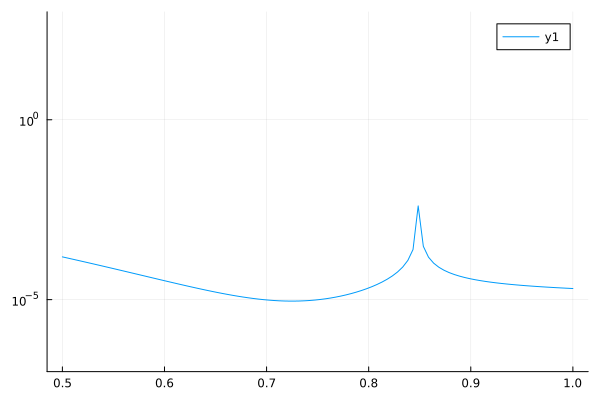

In [107]:
plot(alpharange, 1e-9 ./Gammaphi,yscale=:log10,ylim=(1e-7,1e3))
# plot(alpharange, 1e-9 ./Gamma1,yscale=:log10,ylim=(1e-2,1e7),yticks=10)

# res

In [191]:
Aphi = 1e-6
C = abs(log(2*pi*1e-6))

function decoherence(alpha,t,A,omega_d)
    tmp_Es, tmp_ψs = eigs(KinPot12 + alpha .* Potential3, nev=2, which=:SR, tol=0.0, maxiter=10000)
    M = alpha.*tmp_ψs'*dPot3_dphi()*tmp_ψs
    dωq = abs(M[2,2] - M[1,1])
    Γphi = Aphi*C*dωq
    if omega_d == nothing
        Δ = 0
    else
        Δ = real(tmp_Es[2] - tmp_Es[1]) - omega_d
    end
    d = abs((tmp_ψs'*chargecoupling*tmp_ψs)[1,2])
    if A == nothing
        A = pi/(d*t)
    end
    factor = Γphi/(16*(A^2*d^2+Δ^2)^2)
    theta = A*d*t
    C1 = A^4*d^4*(3*t*cos(theta)+2*t)
    C2 = A^3*d^3*(sin(theta)^3+sin(theta))
    C3 = A^2*d^2*Δ^2*(8*t*cos(theta)+4*t)
    C4 = 4*Δ^4*t*cos(theta)
    C5 = -Δ^2*A*d*sin(2*theta)
    return factor*(C1 + C2 + C3 + C4 + C5)
end

decoherence (generic function with 1 method)

In [192]:
N = 20
decos = zeros(N,N)
alphas = LinRange(0.5,1,N)
ts = LinRange(1,20,N)
for (i,alpha) in enumerate(alphas)
    for (j,t) in enumerate(ts)
        decos[i,j] = decoherence(alpha,t,nothing,nothing)
    end
end

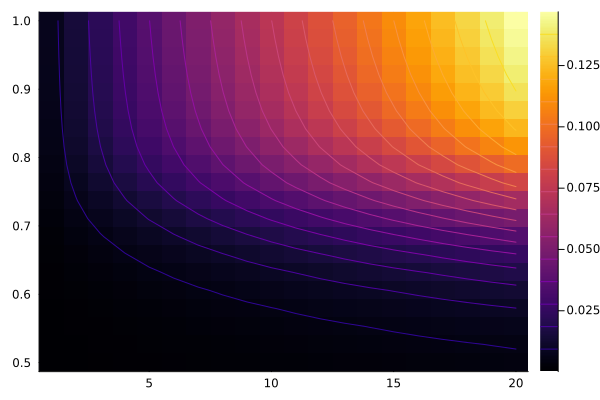

In [197]:
heatmap(ts,alphas,abs.(decos2)*100)
contour!(ts,alphas,abs.(decos)*100,color=:plasma)

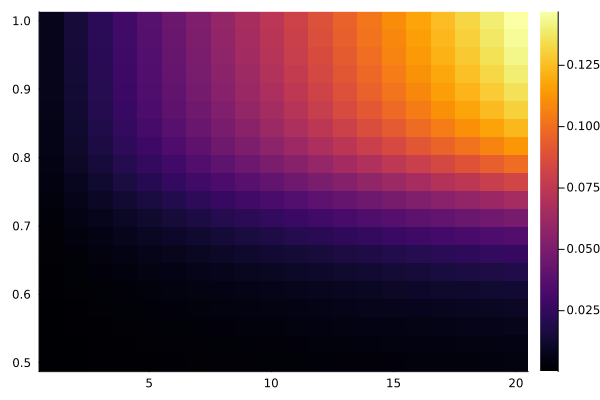

In [150]:
heatmap(ts,alphas,abs.(decos)*100)